# The "kitchen sink" problem

In [2]:
%matplotlib inline
import numpy as np
from scipy.optimize import fsolve
from scipy import integrate
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from clawpack.visclaw.ianimate import ianimate
import matplotlib
plt.style.use('seaborn-talk')
from IPython.display import HTML

Our next example is something you can experiment with in your own home.  Go to the kitchen sink, position the faucet over a flat part of the sink (not over the drain), and turn it on.  Carefully examine the flow of water in the sink.  You will see that near the jet of water coming from the faucet, there is a region of very shallow, very fast-flowing water.  Then at a certain distance, the water suddenly becomes deeper and slower moving.  This jump is relatively stable and will approximately form a circle if the bottom of the sink is flat around the area under the faucet.

Here's a demonstration in case you don't have a sink handy:

In [3]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/V_obYAebT8g" frameborder="0" allowfullscreen></iframe>')


/home/burak/Documents/env3/lib/python3.6/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


This jump (known as a *hydraulic jump*) is a shock wave and the entire flow can be modeled as a sort of multidimensional Riemann problem.  Instead of left and right states, we have *inner* and *outer* states.  To investigate this phenomenon we'll again use the shallow water equations.  We'll assume the flow has cylindrical symmetry -- in other words, it depends on the distance away from the center (where water falls from the faucet), but not on the angular coordinate.

## Shallow water flow in cylindrical symmetry
The amount of water contained in an annular region $r_1< r <r_2$ is proportional to $r$ and to the depth, so in cylindrical coordinates the conserved mass is $rh$.  Similarly, the conserved momentum is $rhu$.  The conservation laws for these two quantities read
\begin{align}
    (rh)_t + (rhu)_r & = 0 \label{mass1} \\
    (rhu)_t + (rhu^2)_r + r \left(\frac{1}{2}gh^2\right)_r = 0. \label{mom1}
\end{align}


We have placed the coordinate $r$ inside the time derivative in order to emphasize what the conserved quantities are; of course, $r$ does not depend on $t$.  We can rewrite the equations above so that the left hand side is identical to the 1D shallow water equations, but at the cost of introducing geometric *source terms* on the right:
\begin{align}
    h_t + (hu)_r & = -\frac{hu}{r} \label{mass2} \\
    (hu)_t + \left(hu^2 + \frac{1}{2}gh^2\right)_r & = -\frac{hu^2}{r} \label{mom2}
\end{align}

### Steady profiles
Let us first look for time-independent solutions of the equations above.  Setting the time derivatives to zero, we obtain

\begin{align}
    (rhu)_r & = 0 \label{constant_mass} \\
    \left(hu^2 + \frac{1}{2}gh^2\right)_r & = -\frac{hu^2}{r} \label{constant_2}
\end{align}
Equation (\ref{constant_mass}) can be integrated to obtain $rhu = \beta$ where $\beta$ (evidently the flux through a circle) is an arbitrary constant.  Using this to eliminate $u$ in equation (\ref{constant_2}) leads to the ODE

\begin{align} \label{hdiff0}
    h'(r) = \frac{h}{\frac{g}{\beta^2} r^3 h^3 -r}.
\end{align}

Let us define the **Froude number**, which is a measure of the ratio of fluid velocity to gravitational effects:

$$
    F = \frac{|u|}{\sqrt{gh}}
$$

We say that the flow is *subcritical* if $F<1$, and *supercritical* if $F>1$.  Since the characteristic speeds for the system are $u \pm \sqrt{gh}$, in generic terms the flow is *subsonic* if $F<1$ and *supersonic* if $F>1$.  We can rewrite (\ref{hdiff0}) as

\begin{align} \label{hdiff}
    h'(r) = \frac{h}{r} \cdot \frac{F^2}{1-F^2}.
\end{align}
The sign of $h'(r)$ thus depends entirely on the Froude number.  Notice that in the limit $F\to\infty$ (i.e., in the absence of gravity), we have simply $h'(r) = -h/r$, with solution $h \propto 1/r$.  This corresponds to the purely geometric effect of water spreading as it flows outward at constant velocity.

Notice also that the RHS of \eqref{hdiff} blows up as $|F|$ approaches unity.  This means that a smooth steady flow must be either subsonic everywhere or supersonic everywhere; there is no smooth way to transition between the two.

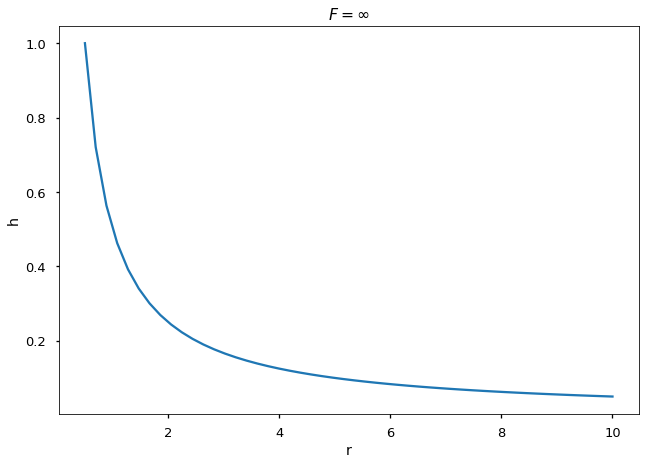

In [4]:
def steady_rhs(h,r,alpha,g=1.):
    return h/(g/alpha**2 * r**3 * h**3 - r)

r = np.linspace(0.5, 10)
h0 = 1.; u0 = 1.; alpha = r[0]*h0*u0
h = np.squeeze(integrate.odeint(steady_rhs,h0,r,args=(alpha,0.)))  # Zero gravity
plt.plot(r,h);  plt.title('$F=\infty$'); plt.xlabel('r'); plt.ylabel('h');

### Supercritical flow ($F>1$)
Suppose we have a steady flow that is supercritical (everywhere, by the argument above).
In the presence of gravity, $h$ is still a decreasing function of $r$ if $F>1$.  We see that the depth $h$ falls off somewhat faster than $1/r$.  Since $rhu$ is constant, this means that the velocity $u=1/(hr)$ must increase with $r$.  Hence the flow becomes shallower and faster as it moves outward; the Froude number increases.  Asymptotically, the falloff in depth approaches the $1/r$ rate and the velocity approaches a constant value.

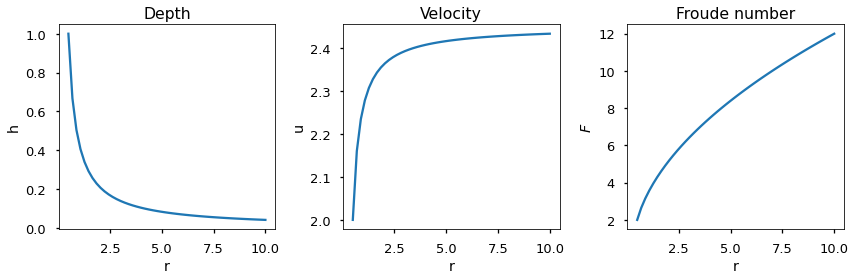

In [5]:
h0 = 1.; u0 = 2.; alpha = r[0]*h0*u0; g=1.
h = np.squeeze(integrate.odeint(steady_rhs,h0,r,args=(alpha,g)));
u = alpha/(h*r)
plt.figure(figsize=(12,4));
plt.subplot(1,3,1); plt.title('Depth'); 
plt.xlabel('r'); plt.ylabel('h');
plt.plot(r,h);
plt.subplot(1,3,2);  plt.title('Velocity'); 
plt.xlabel('r'); plt.ylabel('u');
plt.plot(r,alpha/(r*h));
plt.subplot(1,3,3); plt.title('Froude number'); 
plt.xlabel('r'); plt.ylabel('$F$');
plt.plot(r,alpha/(r*h*np.sqrt(g*h)));
plt.tight_layout();

### Subcritical flow ($F<1$)

Meanwhile, if the flow is subsonic then $h(r)$ is increasing and the steady profile is subsonic everywhere.

In [ ]:
h0 = 1.; u0 = 0.5; alpha = r[0]*h0*u0; g=1.
h = np.squeeze(integrate.odeint(steady_rhs,h0,r,args=(alpha,g)));
u = alpha/(h*r)
plt.figure(figsize=(12,4));
plt.subplot(1,3,1); plt.title('Depth');
plt.xlabel('r'); plt.ylabel('h');
plt.plot(r,h);
plt.subplot(1,3,2);  plt.title('Velocity');
plt.xlabel('r'); plt.ylabel('u');
plt.plot(r,alpha/(r*h));
plt.subplot(1,3,3); plt.title('Froude number');
plt.xlabel('r'); plt.ylabel('$F$');
plt.plot(r,alpha/(r*h*np.sqrt(g*h)));
plt.tight_layout();

A different and complementary approach to deriving steady profiles (see <cite data-cite="Ivings1998"><a href="riemann.html#zobeyer2013radial">(Zobeyer 2013)</a></cite> is to recognize that in such a solution, the energy $gh^2 + \frac{hu^2}{2}$ is constant.  More simply

$$
    h + \frac{u^2}{2g} = \gamma,
$$
for some constant $\gamma$.  Combining this with conservation of mass yields a cubic equation for the depth:
$$
h^3 -  \beta h^2 + \frac{\alpha^2}{2gr^2}=0.
$$
In non-dimensionalized coordinates, with $H=h/h_0$, $R = r/r_0$, and letting $F_0$ denote the Froude number at $r_0$, this becomes simply
$$
H^3 - \left(1+\frac{1}{2}F_0^2\right)H^2 + \frac{F_0^2}{2R^2} = 0.
$$
This can also be solved to obtain the depth as a function of radius; the result, of course, agrees with that obtained from the differential equation above.  The supercritical and subcritical flows correspond to different roots of the cubic.

## The hydraulic jump
To transition from supersonic to subsonic, the flow must *jump* over the pole of the ODE above, through the presence of a hydraulic jump.  This is a standing shock wave; since we have an outward-oriented flow, this jump must be a 1-shock (in order to be stationary).

### Rankine-Hugoniot jump conditions
The jump condition arising from the continuity equation is the same as that obtained for shallow water in one dimension, since the value of $r$ at the shock location simply divides out:

$$
    s (h_r - h_l) = h_r u_r - h_l u_l.
$$

The momentum equation (\ref{mom1}) seems harder to deal with.  We might try to derive appropriate conditions from (\ref{mom2}) by using some averaged values of $h$ and $u$ to model the source term as a delta function (this makes sense for the shallow water equations with a bathymetric source term).  A simpler tactic is to return to (\ref{mom1}), which yields the jump condition

$$
    s (r h_r u_r - r h_l u_l) = r h_r u_r^2 + \frac{gr}{2}h_r^2 - r h_l u_l^2 - \frac{gr}{2}h_l^2.
$$
Again, we can divide through by $r$ to obtain the same jump condition that is familiar from the one-dimensional shallow water equations:
$$
    s (h_r u_r - h_l u_l) = h_r u_r^2 - h_l u_l^2 + \frac{g}{2}(h_r^2 - h_l^2).
$$
It makes sense that the jump conditions for the cylindrical SW system are the same as those for the 1D SW system, since a cylindrical shock occurs at a single value of $r$.

Unlike the 1D case, however, it does not make sense to consider a Riemann problem in which the left and right states are uniform in space, since those are not temporally steady states of the system.  Instead, we can consider two steady profiles with a jump between them.  For infinitesimal times, in a neighborhood of the initial jump, the solution would then be close to the solution of the 1D problem; at later times it could be much more complex, as the waves from the Riemann problem interact with the structure of the steady states.  But if the Riemann solution consists of a single stationary shock, then the solution will be steady for all time.  This is just the kind of solution that is relevant to our kitchen sink experiment.

### A stationary 1-shock
We know from the analysis above that the hydraulic jump we are looking for is a stationary 1-shock (if it were a 2-shock it would necessarily move outward, since the fluid velocity $u>0$).  In this case the shock speed $s=0$ and the first jump condition is simply

$$
    h_r u_r = h_l u_l.
$$
From (LeVeque, pp. 265-266, Eqn. (13.18)), we have that for 1-shocks,

$$
    h_r u_r = h_l u_l + \alpha\left[ u_l - \sqrt{gh_l\left(1+\frac{\alpha}{h_l}\right)\left(1+\frac{\alpha}{2h_l}\right)}\right],
$$
where $\alpha = h_r - h_l$.  We can find a shock that satisfies the jump condition either by setting $\alpha=0$ (which is the uninteresting case where there is no jump) or by setting the quantity in brackets equal to zero.  The latter condition yields
$$
    \alpha = \frac{-3h_l \pm \sqrt{h_l^2 + 8 h_l u_l^2/g}}{2}
$$
Since we know the depth should increase (from left to right) at the hydraulic jump, we take the plus sign.  Then the value above can be written in terms of the Froude number as

\begin{align}
    \alpha = \frac{3h_l}{2}\left(\sqrt{1+\frac{8}{9}(F_l^2-1)}-1\right), \label{depth_jump}
\end{align}
where $F_l = u_l/\sqrt{gh_l}$ is the Froude number of the left state.

## A steady solution with a hydraulic jump
To find a steady solution with a hydraulic jump, we impose steady supercritical flow for $r<r_0$, a jump defined by \eqref{depth_jump} at $r=r_0$ (with $h_l$ and $F_l$ being the depth and Froude number just inside the jump radius), and steady subcritical flow for $r>r_0$.  The steady flow profiles can be obtained by numerically integrating \eqref{hdiff0}.

The code below implements this solution.  The parameters $h_{in}, u_{in}$ are the depth and velocity at the inner radius of the domain.  The function returns the depth and velocity at equispaced points in $r$, as well as values of $h$ and $u$ that will be needed to impose appropriate boundary conditions via ghost cells in a finite volume simulation.

In [6]:
def initial_and_boundary_data(r_jump = 1.,r_inner = 0.5,r_outer = 5.,
                              num_cells = 501,g=1.,h_in=1.,u_in=2.):

    r = pyclaw.Dimension(r_inner, r_outer, num_cells, name='r')
    rc = r.centers
    i_jump = np.argmin(np.abs(rc-r_jump))

    # Left boundary
    h_inner = h_in
    u_inner = u_in
    beta_inner = r_inner*h_inner*u_inner

    h = 0*rc
    u = 0*rc

    d = r.delta
    rvals = np.insert(rc[:i_jump+1],(0),[rc[0]-2*d,rc[0]-d])
    beta = rvals[0]*h_inner*u_inner

    hh = integrate.odeint(steady_rhs,h_inner,rvals,args=(beta,g))
    hh = np.squeeze(hh)
    uu = beta/(hh*rvals)
    h[:i_jump+1] = np.squeeze(hh[2:])
    u[:i_jump+1] = uu[2:]
    lower_bc_data = [hh[:2], uu[:2]]

    # Jump in h
    # Left side of jump
    h_m = h[i_jump]; u_m = u[i_jump]
    aleph = (-3*h_m+np.sqrt(h_m**2+8*h_m*u_m**2/g))/2.
    # Right side of jump
    h_p = h_m + aleph; u_p = h_m*u_m/h_p
    h[i_jump+1] = h_p; u[i_jump+1] = u_p


    # Outer part of solution
    beta_outer = rc[i_jump+1]*h[i_jump+1]*u[i_jump+1]
    rvals = np.append(rc[i_jump+1:],[rc[-1]+d,rc[-1]+2*d])

    hh = integrate.odeint(steady_rhs,h_p,rvals,args=(beta_outer,g))
    hh = np.squeeze(hh)
    uu = beta_outer/(rvals*hh)
    h[i_jump+1:] = hh[:-2]
    u[i_jump+1:] = uu[:-2]
    upper_bc_data = [hh[-2:],uu[-2:]]
    
    return h, u, upper_bc_data, lower_bc_data, rc

Here's an example of a solution:

(0.5, 5.0)

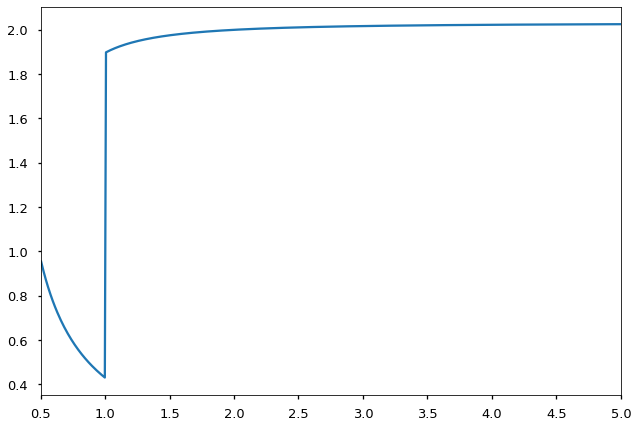

In [7]:
h, u, _, _, rc = initial_and_boundary_data()
plt.plot(rc, h)
plt.xlim(0.5,5)

## Finite volume simulation

To check that the solution we've obtained is truly steady, we set up a finite volume simulation using PyClaw.

In [8]:
def step_radial_src(solver,state,dt):
    """
    Geometric source terms for SW equations with cylindrical symmetry.
    Integrated using a 2-stage, 2nd-order Runge-Kutta method.
    This is a Clawpack-style source term routine, which approximates
    the integral of the source terms over a step.
    """
    dt2 = dt/2.

    q = state.q
    rad = state.grid.r.centers

    h = q[0,:]
    u = q[1,:]/h

    qstar = np.empty(q.shape)

    qstar[0,:] = q[0,:] - dt2/rad * h*u
    qstar[1,:] = q[1,:] - dt2/rad * h*u*u

    h = qstar[0,:]
    u = qstar[1,:]/h

    q[0,:] = q[0,:] - dt/rad * h*u
    q[1,:] = q[1,:] - dt/rad * h*u*u
    
def inner_state(state,dim,t,qbc,auxbc,num_ghost):
    h =  state.problem_data['lower_bc_data'][0]
    u =  state.problem_data['lower_bc_data'][1]
    qbc[0,:num_ghost] = h
    qbc[1,:num_ghost] = h*u
    
def outer_state(state,dim,t,qbc,auxbc,num_ghost):
    h =  state.problem_data['upper_bc_data'][0]
    u =  state.problem_data['upper_bc_data'][1]
    qbc[0,-num_ghost:] = h
    qbc[1,-num_ghost:] = h*u
    
def setup(r_jump=1.,r_inner=0.5,r_outer=3.,num_cells=501,g=1.):
    r = pyclaw.Dimension(r_inner, r_outer, num_cells=num_cells, name='r')
    h, u, upper_bc_data, lower_bc_data, _ = \
            initial_and_boundary_data(r_jump=r_jump,g=g, r_inner=r_inner,
                                      r_outer=r_outer, num_cells=num_cells)
    
    solver = pyclaw.ClawSolver1D(riemann_solver=riemann.shallow_roe_with_efix_1D)
    solver.bc_lower[0] = pyclaw.BC.custom
    solver.user_bc_lower = inner_state
    solver.bc_upper[0] = pyclaw.BC.custom
    solver.user_bc_upper = outer_state
    solver.step_source = step_radial_src
    domain = pyclaw.Domain([r])
    state = pyclaw.State(domain,solver.num_eqn)
    state.problem_data['grav'] = g
    state.problem_data['lower_bc_data'] = lower_bc_data
    state.problem_data['upper_bc_data'] = upper_bc_data

    state.q[0,:] = h
    state.q[1,:] = h*u

    claw = pyclaw.Controller()
    claw.solver = solver
    claw.solution = pyclaw.Solution(state,domain)
    claw.tfinal = 15.0
    claw.keep_copy = True
    claw.num_output_times = 50
    return claw

In [9]:
claw = setup()
claw.verbosity=0
claw.run()

anim = ianimate(claw)
plt.close('all')
HTML(anim.to_jshtml())

### Dirichlet BCs with transition from super- to subsonic flow generically create a hydraulic jump

Although the result above took a lot of work, it is not very impressive -- it doesn't do anything!  You might be wondering whether this steady solution is dynamically stable -- i.e., whether the flow will converge to this state if it is initially different.  The answer is yes; in fact, any boundary data that implies a transition from supercritical to subcritical flow will lead to a hydraulic jump.  In the example below, we impose such boundary data but initialize $h$ and $u$ with constant values, to show the emergence of the jump.

In [ ]:
def setup_constant_initial_data(r_jump=1.,r_inner=0.5,r_outer=3.,
                                num_cells=501,g=1.):
    r = pyclaw.Dimension(r_inner, r_outer, num_cells=num_cells, name='r')
    
    solver = pyclaw.ClawSolver1D(riemann_solver=riemann.shallow_roe_with_efix_1D)
    solver.bc_lower[0] = pyclaw.BC.custom
    solver.user_bc_lower = inner_state
    solver.bc_upper[0] = pyclaw.BC.custom
    solver.user_bc_upper = outer_state
    solver.step_source = step_radial_src
    domain = pyclaw.Domain([r])
    state = pyclaw.State(domain,solver.num_eqn)
    state.problem_data['grav'] = g
    
    hl = 0.5; hul = 3.
    hr = 2.; hur = 0.1
    state.problem_data['lower_bc_data'] = np.array([[hl,hl],[hul,hul]])
    state.problem_data['upper_bc_data'] = np.array([[hr,hr],[hur,hur]])

    state.q[0,:] = 1.
    state.q[1,:] = 0.

    claw = pyclaw.Controller()
    claw.solver = solver
    claw.solution = pyclaw.Solution(state,domain)
    claw.tfinal = 15.0
    claw.keep_copy = True
    claw.num_output_times = 50
    return claw

In [ ]:
claw = setup_constant_initial_data()
claw.verbosity=0
claw.run()

anim = ianimate(claw)
HTML(anim.to_jshtml())

## Comparison with experimental results
We may ask how well our model corresponds to reality.  There are many approximations made in deriving the shallow water equations used here; perhaps most notably, we have completely neglected viscosity and surface tension.  Viscosity in particular is believed to be very important in the very shallow flow just inside the jump radius.

### Inflow conditions
Experimentally it is difficult to measure the depth near the jet.  We can eliminate that dependence (and the apparent dependence on our choice of inner radius) by considering the radius of the vertical jet, which we denote by $a$, and the  flow rate, denoted by $Q$.  Then

$$
Q = u_{jet} \pi a^2 = 2 \pi r u(r) h(r) 
$$
The first expression comes from considering flow in the jet, while the second comes from considering flow through a circle anywhere outside the jet (centered on the jet).  If we suppose that $u$ is approximately constant (recall that it actually increases somewhat with $r$) then we have $u(r)\approx u_{jet}$, and consequently
$$
h(r) = a^2/(2r).
$$
Using these equations, with a specified flow rate $Q$ and jet radius $a$, along with a chosen inner radius $r_0\ge a$, we can determine the correct values of $h_0$ and $u_0.$  It can be shown that the results obtained in this way are only very weakly sensitive to our choice of $r_0$.

In [ ]:
def compute_inner_values(Q,a,r0):
    """
        Q: flow rate
        a: jet radius
        r0: inner domain radius
    """
    assert r0 >= a
    h0 = a**2/(2*r0)
    u0 = Q/(2*np.pi*r0*h0)
    return h0, u0

### Locating the jump
In the examples above, we selected the boundary data based on a prescribed jump location.  But in practice we can't choose where the jump is -- we'd like to predict that!

We can predict the location of the jump based on prescribed inflow conditions ($r_0, h_0, u_0$ and a prescribed far-field depth $h_\infty$) as follows:

1.  Set $\beta = r_0 h_0 u_0$.  Choose a finite outer radius $r_\infty \gg r_0$.  Set $u_\infty$ so that $r_\infty h_\infty u_\infty = \beta$.
2.  Integrate (\ref{hdiff}) outward from $(r_0,h_0)$ to obtain a profile $h_\text{outward}$.
3.  Integrate (\ref{hdiff}) inward from $(r_\infty, h_\infty)$ to obtain a profile $h_\text{inward}$.
4.  Compute $\phi(r) = h_\text{outward} - h_\text{inward}$ and determine the value of $r$ such that $\phi(r) = \alpha$, with $\alpha$ given by (\ref{depth_jump}).

In [ ]:
def jump_location(Q,r_jet,h_inf,r_inf=100.,g=1.,r0=None,tol=1./10000):
    r"""Predict location of hydraulic jump for given inner 
        radius flow and asymptotic depth."""
    
    if r0 == None:
        r0 = r_jet
    h0, u0 = compute_inner_values(Q,r_jet,r0)

    F_in = u0/np.sqrt(g*h0)  # Inflow Froude number
    assert F_in > 1  # Initial flow must be supercritical
    
    r = np.linspace(r0,r_inf,int(round(1./tol)))
    beta = r0 * h0 * u0
    u_inf = u0 * (r0/r_inf) * (h0/h_inf)
    
    F_inf = u_inf/np.sqrt(g*h_inf)  # Far-field Froude number
    assert F_inf < 1  # Far field flow must be subcritical
    
    # Integrate outward
    hh_in = np.squeeze(integrate.odeint(steady_rhs,h0,r,args=(beta,g)))
    uu_in = beta/(r*hh_in)
    
    hh_out = np.squeeze(integrate.odeint(steady_rhs,h_inf,-r[::-1],args=(beta,g)))
    hh_out = hh_out[::-1]
    
    F_l = uu_in/np.sqrt(g*hh_in) # Froude number for left state
    phi = hh_in - hh_out + 1.5*hh_in*(np.sqrt(1.+8./9.*(F_l**2-1.))-1)
    
    jump_loc = np.argmin(np.abs(phi))
    profile = 0*r
    profile[:jump_loc] = hh_in[:jump_loc]
    profile[jump_loc:] = hh_out[jump_loc:]
    return r[jump_loc], r, profile

In [ ]:
r_jump, r, profile = jump_location(Q=200.,r_jet=1.,h_inf=1.,g=980.,tol=1.e-6)
print('Jump radius: '+str(r_jump)+' cm')
plt.clf()
plt.plot(r,profile)
plt.xlim(r[0],10);

### Watson's experiment
Here we use data from an experiment conducted in <cite data-cite="watson1964radial"><a href="riemann.html#watson1964radial">(Watson, 1964)</a></cite>; see p. 496 therein.  The unit of length therein is feet; here we have converted everything to centimeters.  The experimental jump location is at a radius of about 17 cm.  Let's see what our model gives.

In [ ]:
Q = 202. # Flow rate (in cm^3/s)
r_jet = 0.3175 # Nozzle radius (in cm)
h_inf = 0.343 # Depth at infinity (in cm)
g = 980. # Gravity (in cm/s^2)
r_jump, r, profile = jump_location(Q,r_jet,h_inf,r_inf=500.,g=980.,tol=1.e-6)
print('Predicted jump radius: '+str(r_jump)+' cm')
print('Measured jump radius: 17 cm')
plt.plot(r,profile)
plt.xlim(r[0],r[-1]);

Clearly, some of the effects we have ignored must be important!  In particular, as Watson (and others) argue, viscosity or friction becomes very significant in the shallow flow before the jump, causing the jump to emerge much closer to the jet than this inviscid model predicts.

### Experiments of Craik et. al.
Here we compare with two more experiments; see Table 1 of <cite data-cite="craik1981circular"><a href="riemann.html#craik1981circular">(Craik et. al., 1981)</a></cite>.

In [ ]:
Q = 4.48
r_jet = 0.1
h_inf = 0.18
r_jump, r, profile = jump_location(Q,r_jet,h_inf,r_inf=50.,g=980.,tol=1.e-6)
print('Predicted jump radius: '+str(r_jump)+' cm')
print('Measured jump radius: 1.2 cm')
plt.plot(r,profile)
plt.xlim(r[0],r[-1]);

In [ ]:
Q = 26.
r_jet = 0.215
h_inf = 0.33
r_jump, r, profile = jump_location(Q,r_jet,h_inf,r_inf=200.,g=980.,tol=1.e-6)
print('Predicted jump radius: '+str(r_jump)+' cm')
print('Measured jump radius: 2.3 cm')
plt.plot(r,profile)
plt.xlim(r[0],r[-1]);

The difference is less extreme, but still very substantial.  It is worth noting also that if we consider water flowing onto an infinite flat plate, the purely hyperbolic model (with no viscosity or friction) doesn't predict any jump at all, because there is no mechanism forcing the flow to transition to a subsonic state.  We can observe this in the simulation if we set the boundary condition at the outer radius to outflow.

In the simulation below, we start with a steady-state solution involving a hydraulic jump, but allow outflow at the outer boundary ((here this is imposed approximately using zero-order extrapolation).

In [ ]:
claw = setup()
claw.solver.bc_upper[0] = pyclaw.BC.extrap
claw.verbosity = 0
claw.run()

In [ ]:
anim = ianimate(claw);
plt.close('all')
HTML(anim.to_jshtml())